# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [3]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [4]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [5]:
Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [11]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 2.0 Training loss: 1.0699 Explore P: 0.9998
Episode: 2 Total reward: 22.0 Training loss: 1.0614 Explore P: 0.9976
Episode: 3 Total reward: 17.0 Training loss: 1.0420 Explore P: 0.9959
Episode: 4 Total reward: 16.0 Training loss: 1.0396 Explore P: 0.9944
Episode: 5 Total reward: 15.0 Training loss: 1.0226 Explore P: 0.9929
Episode: 6 Total reward: 10.0 Training loss: 1.0071 Explore P: 0.9919
Episode: 7 Total reward: 10.0 Training loss: 1.0922 Explore P: 0.9909
Episode: 8 Total reward: 45.0 Training loss: 1.0304 Explore P: 0.9865
Episode: 9 Total reward: 11.0 Training loss: 1.0812 Explore P: 0.9855
Episode: 10 Total reward: 14.0 Training loss: 1.0358 Explore P: 0.9841
Episode: 11 Total reward: 17.0 Training loss: 1.1156 Explore P: 0.9824
Episode: 12 Total reward: 26.0 Training loss: 1.0695 Explore P: 0.9799
Episode: 13 Total reward: 25.0 Training loss: 1.0227 Explore P: 0.9775
Episode: 14 Total reward: 16.0 Training loss: 1.0049 Explore P: 0.9759
Episode: 15 Tota

Episode: 117 Total reward: 29.0 Training loss: 79.3176 Explore P: 0.7862
Episode: 118 Total reward: 18.0 Training loss: 1.9413 Explore P: 0.7848
Episode: 119 Total reward: 12.0 Training loss: 219.5486 Explore P: 0.7839
Episode: 120 Total reward: 19.0 Training loss: 111.5701 Explore P: 0.7824
Episode: 121 Total reward: 12.0 Training loss: 82.9906 Explore P: 0.7815
Episode: 122 Total reward: 15.0 Training loss: 170.6405 Explore P: 0.7803
Episode: 123 Total reward: 11.0 Training loss: 5.0764 Explore P: 0.7795
Episode: 124 Total reward: 22.0 Training loss: 122.5777 Explore P: 0.7778
Episode: 125 Total reward: 12.0 Training loss: 57.5698 Explore P: 0.7769
Episode: 126 Total reward: 12.0 Training loss: 1.9285 Explore P: 0.7759
Episode: 127 Total reward: 11.0 Training loss: 237.6936 Explore P: 0.7751
Episode: 128 Total reward: 9.0 Training loss: 119.2509 Explore P: 0.7744
Episode: 129 Total reward: 19.0 Training loss: 59.6291 Explore P: 0.7730
Episode: 130 Total reward: 11.0 Training loss: 4.

Episode: 231 Total reward: 14.0 Training loss: 59.8939 Explore P: 0.6554
Episode: 232 Total reward: 14.0 Training loss: 28.2389 Explore P: 0.6545
Episode: 233 Total reward: 15.0 Training loss: 56.8860 Explore P: 0.6535
Episode: 234 Total reward: 24.0 Training loss: 62.8056 Explore P: 0.6519
Episode: 235 Total reward: 11.0 Training loss: 55.5959 Explore P: 0.6512
Episode: 236 Total reward: 13.0 Training loss: 2.1602 Explore P: 0.6504
Episode: 237 Total reward: 15.0 Training loss: 79.6792 Explore P: 0.6494
Episode: 238 Total reward: 20.0 Training loss: 57.3186 Explore P: 0.6482
Episode: 239 Total reward: 17.0 Training loss: 2.1632 Explore P: 0.6471
Episode: 240 Total reward: 12.0 Training loss: 22.4429 Explore P: 0.6463
Episode: 241 Total reward: 10.0 Training loss: 2.1320 Explore P: 0.6457
Episode: 242 Total reward: 9.0 Training loss: 52.0045 Explore P: 0.6451
Episode: 243 Total reward: 10.0 Training loss: 1.3325 Explore P: 0.6445
Episode: 244 Total reward: 14.0 Training loss: 70.5708 E

Episode: 344 Total reward: 27.0 Training loss: 1.2903 Explore P: 0.5241
Episode: 345 Total reward: 42.0 Training loss: 1.2634 Explore P: 0.5219
Episode: 346 Total reward: 58.0 Training loss: 0.5161 Explore P: 0.5190
Episode: 347 Total reward: 41.0 Training loss: 22.3751 Explore P: 0.5169
Episode: 348 Total reward: 27.0 Training loss: 1.3643 Explore P: 0.5155
Episode: 349 Total reward: 60.0 Training loss: 0.9433 Explore P: 0.5125
Episode: 350 Total reward: 26.0 Training loss: 28.9780 Explore P: 0.5112
Episode: 351 Total reward: 49.0 Training loss: 1.0038 Explore P: 0.5087
Episode: 352 Total reward: 20.0 Training loss: 23.9415 Explore P: 0.5078
Episode: 353 Total reward: 33.0 Training loss: 28.5406 Explore P: 0.5061
Episode: 354 Total reward: 48.0 Training loss: 35.6093 Explore P: 0.5037
Episode: 355 Total reward: 44.0 Training loss: 12.4602 Explore P: 0.5016
Episode: 356 Total reward: 30.0 Training loss: 0.6575 Explore P: 0.5001
Episode: 357 Total reward: 42.0 Training loss: 1.1176 Expl

Episode: 457 Total reward: 93.0 Training loss: 37.5053 Explore P: 0.2711
Episode: 458 Total reward: 78.0 Training loss: 2.4493 Explore P: 0.2691
Episode: 459 Total reward: 77.0 Training loss: 77.7589 Explore P: 0.2671
Episode: 460 Total reward: 58.0 Training loss: 1.5039 Explore P: 0.2656
Episode: 461 Total reward: 81.0 Training loss: 29.0447 Explore P: 0.2636
Episode: 462 Total reward: 61.0 Training loss: 1.3115 Explore P: 0.2620
Episode: 463 Total reward: 68.0 Training loss: 45.3246 Explore P: 0.2603
Episode: 464 Total reward: 109.0 Training loss: 23.4428 Explore P: 0.2576
Episode: 465 Total reward: 138.0 Training loss: 2.1970 Explore P: 0.2542
Episode: 466 Total reward: 101.0 Training loss: 2.7041 Explore P: 0.2518
Episode: 467 Total reward: 105.0 Training loss: 2.1976 Explore P: 0.2492
Episode: 468 Total reward: 117.0 Training loss: 1.4758 Explore P: 0.2464
Episode: 469 Total reward: 138.0 Training loss: 48.3709 Explore P: 0.2432
Episode: 470 Total reward: 168.0 Training loss: 164.

Episode: 655 Total reward: 14.0 Training loss: 1.4822 Explore P: 0.0320
Episode: 656 Total reward: 10.0 Training loss: 0.9625 Explore P: 0.0319
Episode: 657 Total reward: 10.0 Training loss: 1.3029 Explore P: 0.0319
Episode: 658 Total reward: 9.0 Training loss: 1.1219 Explore P: 0.0319
Episode: 659 Total reward: 9.0 Training loss: 1.1812 Explore P: 0.0319
Episode: 660 Total reward: 8.0 Training loss: 1.6215 Explore P: 0.0319
Episode: 661 Total reward: 11.0 Training loss: 1.0508 Explore P: 0.0318
Episode: 662 Total reward: 14.0 Training loss: 0.8721 Explore P: 0.0318
Episode: 663 Total reward: 10.0 Training loss: 1.7934 Explore P: 0.0318
Episode: 664 Total reward: 12.0 Training loss: 1.4585 Explore P: 0.0318
Episode: 665 Total reward: 8.0 Training loss: 1.2889 Explore P: 0.0317
Episode: 666 Total reward: 9.0 Training loss: 1.2616 Explore P: 0.0317
Episode: 667 Total reward: 10.0 Training loss: 3.1264 Explore P: 0.0317
Episode: 668 Total reward: 8.0 Training loss: 1.3397 Explore P: 0.031

Episode: 883 Total reward: 177.0 Training loss: 0.0557 Explore P: 0.0112
Episode: 885 Total reward: 140.0 Training loss: 0.0765 Explore P: 0.0112
Episode: 887 Total reward: 170.0 Training loss: 0.0433 Explore P: 0.0111
Episode: 890 Total reward: 46.0 Training loss: 0.0940 Explore P: 0.0111
Episode: 893 Total reward: 99.0 Training loss: 201.9364 Explore P: 0.0110
Episode: 896 Total reward: 99.0 Training loss: 0.0413 Explore P: 0.0110
Episode: 899 Total reward: 99.0 Training loss: 0.0570 Explore P: 0.0109
Episode: 901 Total reward: 133.0 Training loss: 0.2602 Explore P: 0.0109
Episode: 904 Total reward: 99.0 Training loss: 0.0477 Explore P: 0.0108
Episode: 907 Total reward: 43.0 Training loss: 0.1238 Explore P: 0.0108
Episode: 910 Total reward: 99.0 Training loss: 0.1201 Explore P: 0.0108
Episode: 912 Total reward: 170.0 Training loss: 0.0808 Explore P: 0.0107
Episode: 915 Total reward: 99.0 Training loss: 0.0775 Explore P: 0.0107
Episode: 918 Total reward: 99.0 Training loss: 0.0588 Exp

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

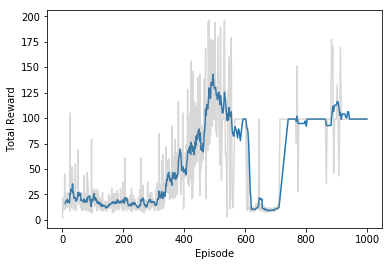

In [14]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.